In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Load the dataset
df = pd.read_csv('gold_price_data.csv')

# Basic exploration
print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nBasic statistics:")
print(df.describe())

Dataset shape: (2290, 6)

First 5 rows:
       Date          SPX        GLD        USO     SLV   EUR/USD
0  1/2/2008  1447.160034  84.860001  78.470001  15.180  1.471692
1  1/3/2008  1447.160034  85.570000  78.370003  15.285  1.474491
2  1/4/2008  1411.630005  85.129997  77.309998  15.167  1.475492
3  1/7/2008  1416.180054  84.769997  75.500000  15.053  1.468299
4  1/8/2008  1390.189941  86.779999  76.059998  15.590  1.557099

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2290 entries, 0 to 2289
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     2290 non-null   object 
 1   SPX      2290 non-null   float64
 2   GLD      2290 non-null   float64
 3   USO      2290 non-null   float64
 4   SLV      2290 non-null   float64
 5   EUR/USD  2290 non-null   float64
dtypes: float64(5), object(1)
memory usage: 107.5+ KB
None

Basic statistics:
               SPX          GLD          USO          SLV      EUR/

In [3]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Check for missing values
print("Missing values:")
print(df.isnull().sum())

Missing values:
Date       0
SPX        0
GLD        0
USO        0
SLV        0
EUR/USD    0
dtype: int64


In [4]:
# Handle missing values (if any)
# Option 1: Forward fill
df1 = df.fillna(method='ffill')
# Option 2: Drop rows with missing values
# df = df.dropna()

# Remove any duplicate dates
df1 = df.drop_duplicates(subset=['Date'])

# Sort by date
df1 = df.sort_values('Date').reset_index(drop=True)

print(f"Clean dataset shape: {df1.shape}")

Clean dataset shape: (2290, 6)


In [5]:
df1==df

,Date,SPX,GLD,USO,SLV,EUR/USD
0,True,True,True,True,True,True
1,True,True,True,True,True,True
2,True,True,True,True,True,True
3,True,True,True,True,True,True
4,True,True,True,True,True,True
...,...,...,...,...,...,...
2285,True,True,True,True,True,True
2286,True,True,True,True,True,True
2287,True,True,True,True,True,True
2288,True,True,True,True,True,True


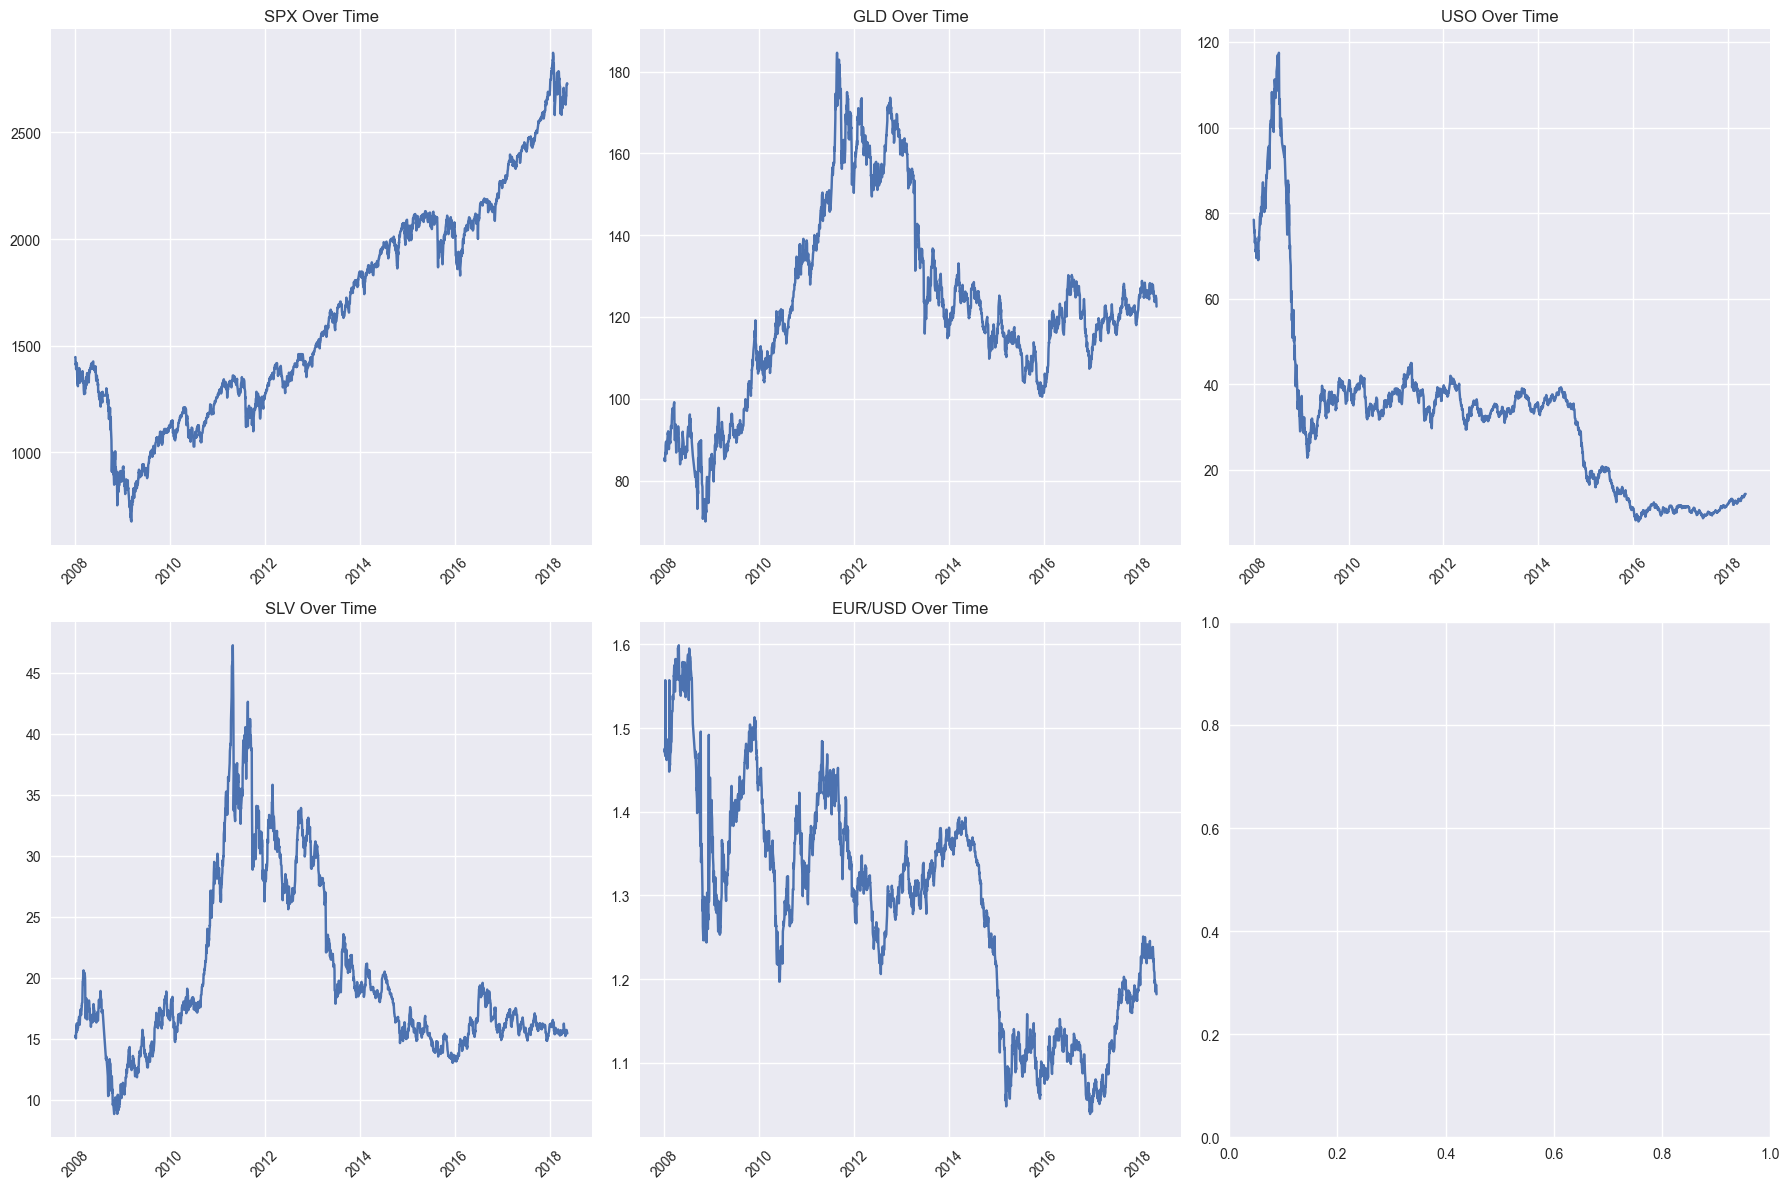

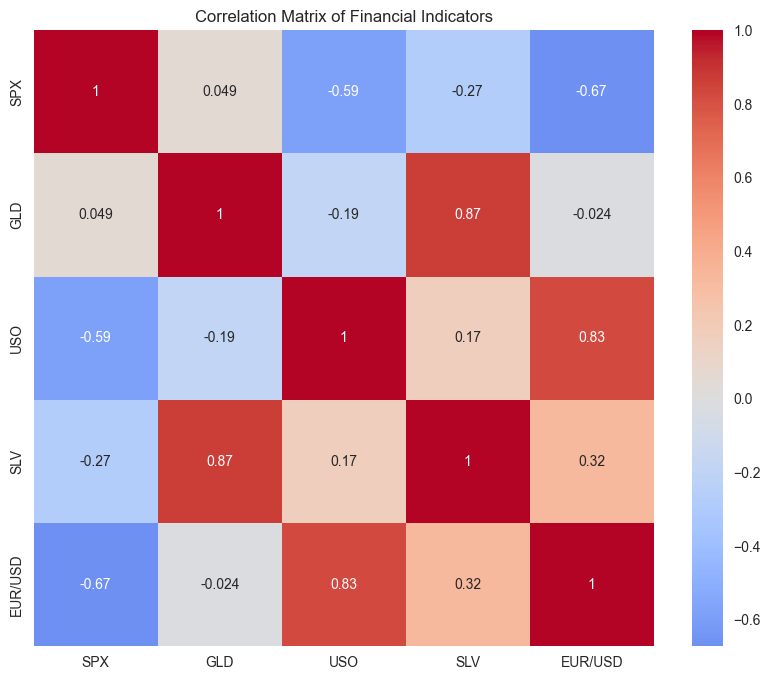

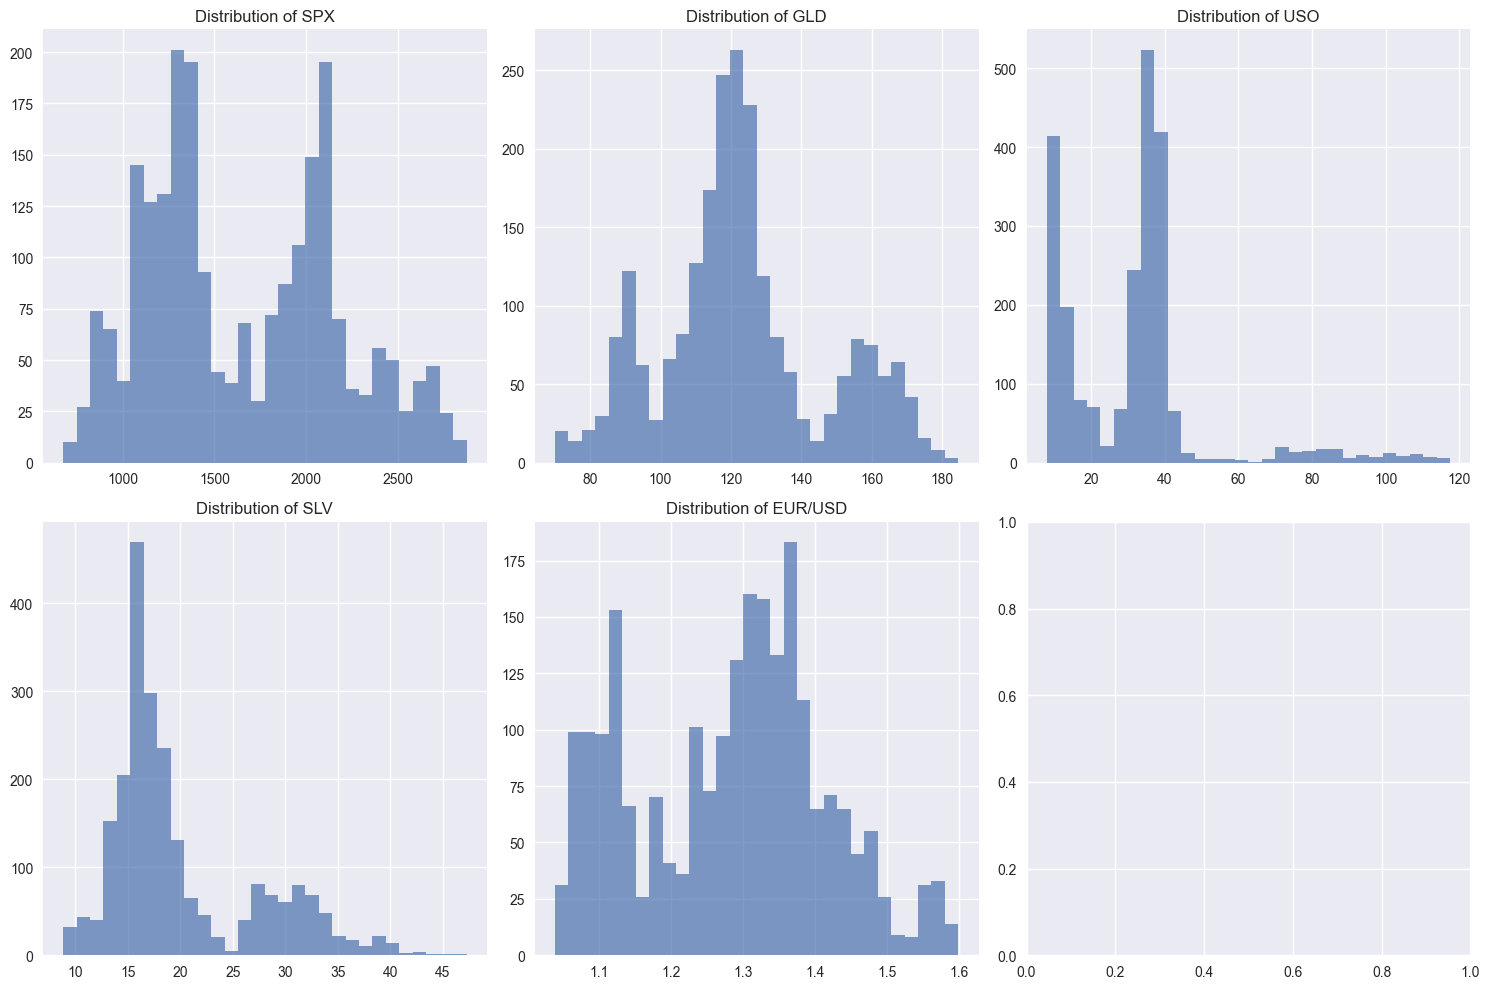

In [6]:
# Set up the plotting style
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Plot each variable over time
variables = ['SPX', 'GLD', 'USO', 'SLV', 'EUR/USD']
for i, var in enumerate(variables):
    row = i // 3
    col = i % 3
    axes[row, col].plot(df['Date'], df[var])
    axes[row, col].set_title(f'{var} Over Time')
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Correlation matrix
correlation_matrix = df[['SPX', 'GLD', 'USO', 'SLV', 'EUR/USD']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Financial Indicators')
plt.show()

# Distribution plots
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, var in enumerate(variables):
    row = i // 3
    col = i % 3
    axes[row, col].hist(df[var], bins=30, alpha=0.7)
    axes[row, col].set_title(f'Distribution of {var}')

plt.tight_layout()
plt.show()

### Feature engineering

In [8]:
# Create additional features
# 1. Moving averages
df['GLD_MA_7'] = df['GLD'].rolling(window=7).mean()
df['GLD_MA_30'] = df['GLD'].rolling(window=30).mean()
df['SPX_MA_7'] = df['SPX'].rolling(window=7).mean()

# 2. Price differences and returns
df['GLD_diff'] = df['GLD'].diff()
df['GLD_pct_change'] = df['GLD'].pct_change()
df['SPX_pct_change'] = df['SPX'].pct_change()

# 3. Volatility indicators
df['GLD_volatility'] = df['GLD'].rolling(window=10).std()

# 4. Technical indicators - RSI (Relative Strength Index)
def calculate_rsi(prices, window=14):
    """
    Calculate Relative Strength Index (RSI)
    RSI = 100 - (100 / (1 + RS))
    RS = Average Gain / Average Loss
    """
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['GLD_RSI'] = calculate_rsi(df['GLD'], window=14)

# 5. Time-based features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek
df['Quarter'] = df['Date'].dt.quarter

# Drop rows with NaN values created by rolling operations
df = df.dropna()

print(f"Dataset with engineered features shape: {df.shape}")

Dataset with engineered features shape: (2261, 18)


### Data Scaling and Normalization

In [9]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# Select features for modeling
feature_columns = ['SPX', 'USO', 'SLV', 'EUR/USD', 'GLD_MA_7', 'GLD_MA_30', 
                   'SPX_MA_7', 'GLD_pct_change', 'SPX_pct_change', 
                   'GLD_volatility', 'Month', 'Quarter']

target_column = 'GLD'

# Prepare features and target
X = df[feature_columns].values
y = df[target_column].values

# Scale features and target separately
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

print(f"Features shape: {X_scaled.shape}")
print(f"Target shape: {y_scaled.shape}")

Features shape: (2261, 12)
Target shape: (2261,)


####  Create Sequences for Time Series

In [10]:
def create_sequences(X, y, sequence_length):
    """
    Create sequences for time series prediction
    """
    X_seq, y_seq = [], []
    
    for i in range(len(X) - sequence_length):
        X_seq.append(X[i:i + sequence_length])
        y_seq.append(y[i + sequence_length])
    
    return np.array(X_seq), np.array(y_seq)

# Define sequence length (lookback period)
SEQUENCE_LENGTH = 30  # Use 30 days of historical data to predict next day

# Create sequences
X_sequences, y_sequences = create_sequences(X_scaled, y_scaled, SEQUENCE_LENGTH)

print(f"Sequence features shape: {X_sequences.shape}")
print(f"Sequence targets shape: {y_sequences.shape}")

Sequence features shape: (2231, 30, 12)
Sequence targets shape: (2231,)


#### Train-Test Split

In [11]:
from sklearn.model_selection import train_test_split

# Time series split (chronological order is important)
split_index = int(0.8 * len(X_sequences))

X_train = X_sequences[:split_index]
X_test = X_sequences[split_index:]
y_train = y_sequences[:split_index]
y_test = y_sequences[split_index:]

print(f"Training set - X: {X_train.shape}, y: {y_train.shape}")
print(f"Testing set - X: {X_test.shape}, y: {y_test.shape}")

Training set - X: (1784, 30, 12), y: (1784,)
Testing set - X: (447, 30, 12), y: (447,)


####  Build the Neural Network Model

In [14]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Build the model
def build_lstm_model(input_shape):
    model = Sequential([
        # First LSTM layer
        LSTM(100, return_sequences=True, input_shape=input_shape),
        Dropout(0.2),
        BatchNormalization(),
        
        # Second LSTM layer
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        BatchNormalization(),
        
        # Dense layers
        Dense(25, activation='relu'),
        Dropout(0.1),
        Dense(1, activation='linear')  # Linear for regression
    ])
    
    return model

# Create model
model = build_lstm_model((SEQUENCE_LENGTH, len(feature_columns)))

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

# Model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 100)             │          45,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 100)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 100)             │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          30,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,301 (301.96 KB)

 Trainable params: 77,001 (300.79 KB)

 Non-trainable params: 300 (1.17 KB)

### Model Training with Callbacks

Epoch 1/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 6s 41ms/step - loss: 0.5145 - mae: 0.5591 - val_loss: 0.0145 - val_mae: 0.1082 - learning_rate: 0.0010
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.2256 - mae: 0.3749 - val_loss: 0.0226 - val_mae: 0.1406 - learning_rate: 0.0010
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.1477 - mae: 0.2999 - val_loss: 0.0069 - val_mae: 0.0694 - learning_rate: 0.0010
Epoch 4/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.1140 - mae: 0.2631 - val_loss: 0.0053 - val_mae: 0.0599 - learning_rate: 0.0010
Epoch 5/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0869 - mae: 0.2338 - val_loss: 0.0035 - val_mae: 0.0437 - learning_rate: 0.0010
Epoch 6/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0643 - mae: 0.2007 - val_loss: 0.0065 - val_mae: 0.0600 - learning_rate: 0.0010
Epoch 7/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0665 - mae: 0.2031 - val_loss: 0.0106 - val_mae: 0.0759 - learning_rate: 0.0010
Epoch 

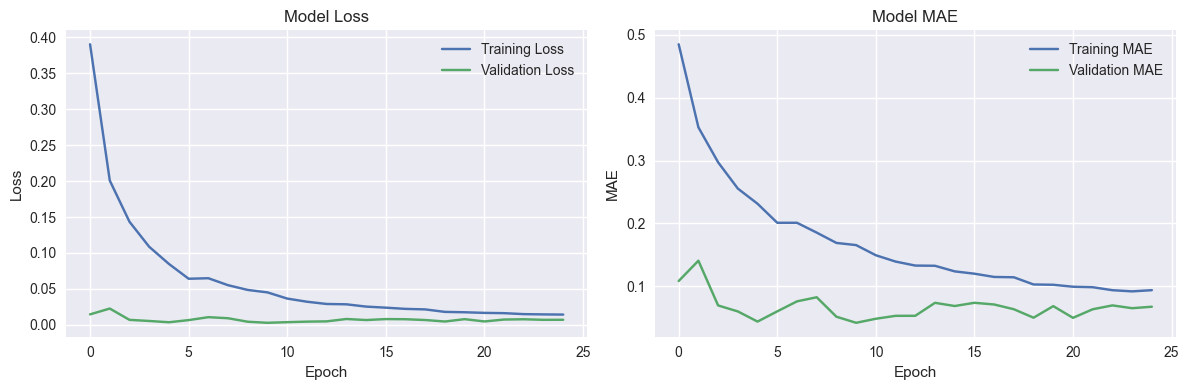

In [15]:
# Define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    min_lr=1e-7
)

# Train the model
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

### Model Evaluation and Prediction

In [16]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and actual values
y_test_actual = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_actual = scaler_y.inverse_transform(y_pred_scaled).flatten()

# Calculate metrics
mse = mean_squared_error(y_test_actual, y_pred_actual)
mae = mean_absolute_error(y_test_actual, y_pred_actual)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred_actual)

print(f"Model Performance Metrics:")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²: {r2:.4f}")

# Percentage error
mape = np.mean(np.abs((y_test_actual - y_pred_actual) / y_test_actual)) * 100
print(f"MAPE: {mape:.2f}%")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Model Performance Metrics:
MSE: 68.9562
MAE: 6.8572
RMSE: 8.3040
R²: -1.8906
MAPE: 5.66%


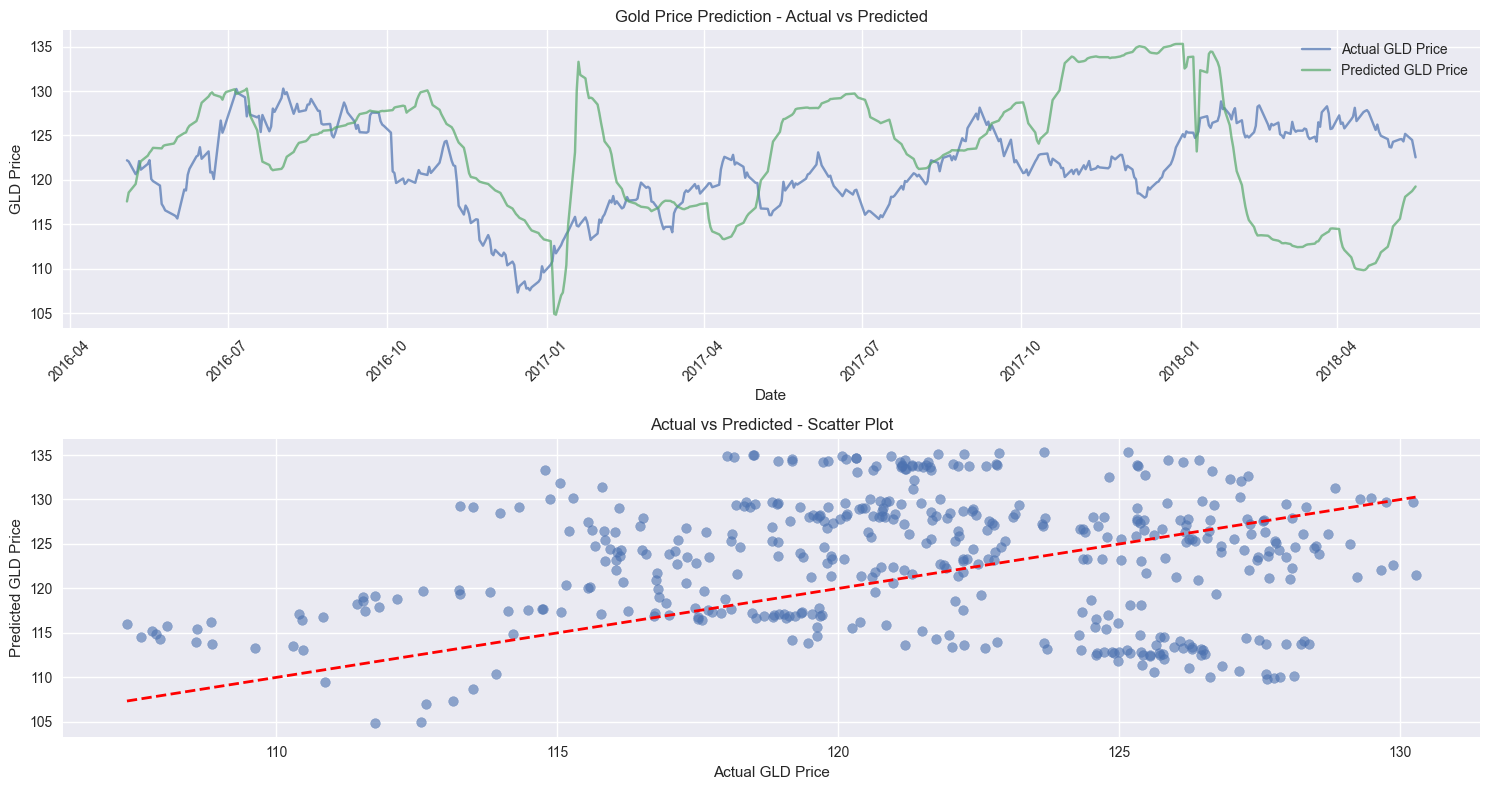

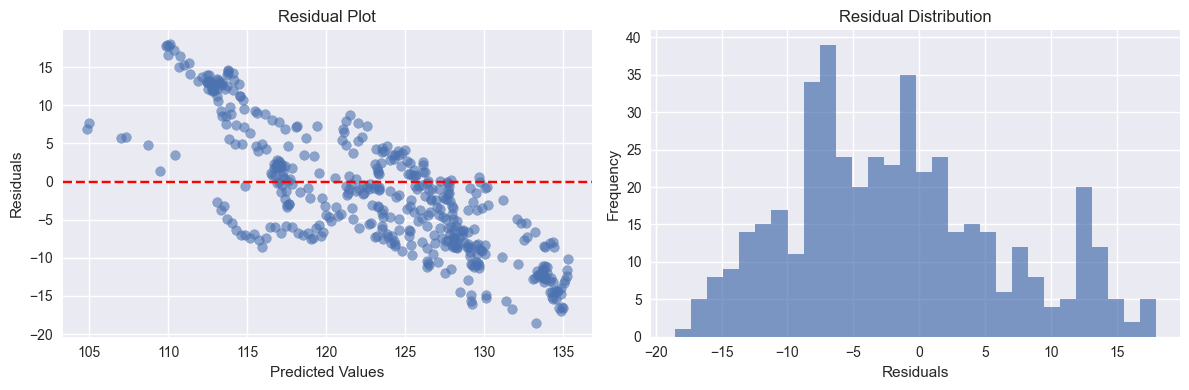

In [17]:
# Plot actual vs predicted
plt.figure(figsize=(15, 8))

# Time series plot
plt.subplot(2, 1, 1)
test_dates = df['Date'].iloc[-len(y_test_actual):].values
plt.plot(test_dates, y_test_actual, label='Actual GLD Price', alpha=0.7)
plt.plot(test_dates, y_pred_actual, label='Predicted GLD Price', alpha=0.7)
plt.title('Gold Price Prediction - Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('GLD Price')
plt.legend()
plt.xticks(rotation=45)

# Scatter plot
plt.subplot(2, 1, 2)
plt.scatter(y_test_actual, y_pred_actual, alpha=0.6)
plt.plot([y_test_actual.min(), y_test_actual.max()], 
         [y_test_actual.min(), y_test_actual.max()], 'r--', lw=2)
plt.xlabel('Actual GLD Price')
plt.ylabel('Predicted GLD Price')
plt.title('Actual vs Predicted - Scatter Plot')

plt.tight_layout()
plt.show()

# Residual analysis
residuals = y_test_actual - y_pred_actual
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_actual, residuals, alpha=0.6)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')

plt.subplot(1, 2, 2)
plt.hist(residuals, bins=30, alpha=0.7)
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residual Distribution')

plt.tight_layout()
plt.show()

### Feature Importance Analysis

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


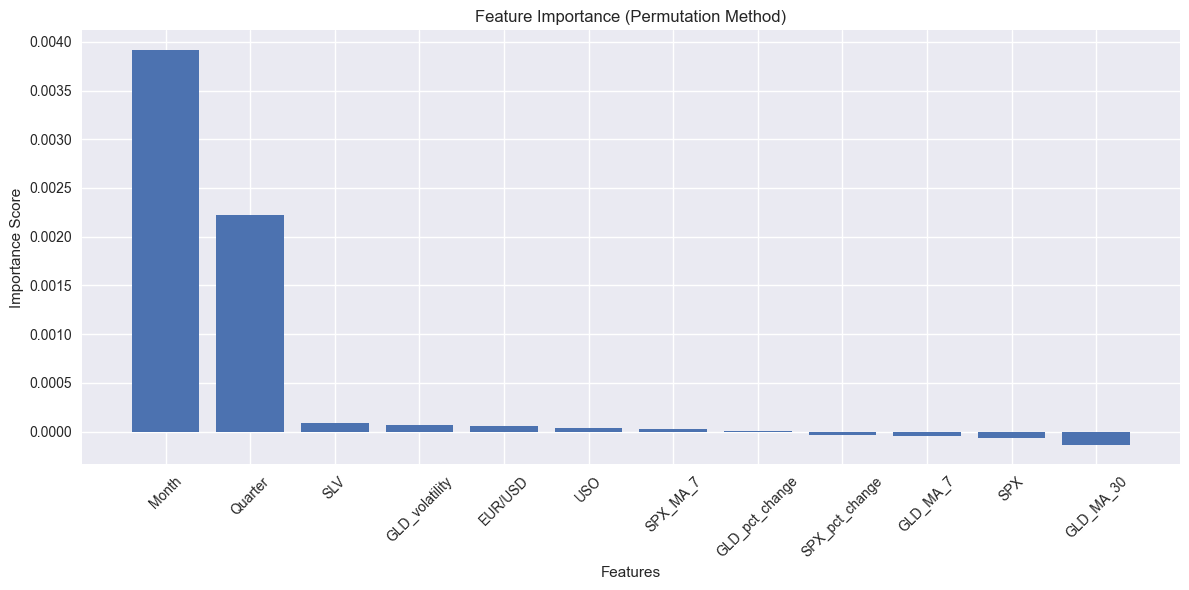

In [18]:
# Create a simple method to analyze feature importance
def analyze_feature_importance(model, X_test, feature_names, n_samples=100):
    """
    Analyze feature importance using permutation method
    """
    baseline_pred = model.predict(X_test[:n_samples])
    baseline_mse = mean_squared_error(y_test[:n_samples], baseline_pred.flatten())
    
    importance_scores = []
    
    for i, feature in enumerate(feature_names):
        # Create a copy of test data
        X_permuted = X_test[:n_samples].copy()
        
        # Permute the feature across all time steps
        np.random.shuffle(X_permuted[:, :, i])
        
        # Get prediction with permuted feature
        permuted_pred = model.predict(X_permuted)
        permuted_mse = mean_squared_error(y_test[:n_samples], permuted_pred.flatten())
        
        # Calculate importance as increase in error
        importance = permuted_mse - baseline_mse
        importance_scores.append(importance)
    
    return importance_scores

# Analyze feature importance
importance_scores = analyze_feature_importance(model, X_test, feature_columns)

# Plot feature importance
plt.figure(figsize=(12, 6))
sorted_idx = np.argsort(importance_scores)[::-1]
plt.bar(range(len(importance_scores)), [importance_scores[i] for i in sorted_idx])
plt.xticks(range(len(importance_scores)), [feature_columns[i] for i in sorted_idx], rotation=45)
plt.title('Feature Importance (Permutation Method)')
plt.xlabel('Features')
plt.ylabel('Importance Score')
plt.tight_layout()
plt.show()

### Model Saving and Future Predictions

In [20]:
# Save the model
model.save('gold_price_prediction_model.h5')

# Save scalers
import joblib
joblib.dump(scaler_X, 'scaler_X.pkl')
joblib.dump(scaler_y, 'scaler_y.pkl')

# Function for future predictions
def predict_future_gold_price(model, scaler_X, scaler_y, last_sequence, days_ahead=1):
    """
    Predict gold price for future days
    """
    predictions = []
    current_sequence = last_sequence.copy()
    
    for _ in range(days_ahead):
        # Predict next day
        next_pred_scaled = model.predict(current_sequence.reshape(1, *current_sequence.shape))
        next_pred = scaler_y.inverse_transform(next_pred_scaled)[0, 0]
        predictions.append(next_pred)
        
        # Update sequence (this is simplified - in practice, you'd need new feature values)
        # For now, we'll just use the prediction as the new GLD value
        # In reality, you'd need fresh data for other features
        
    return predictions

# Example: Predict next 5 days
last_sequence = X_test[-1]  # Last sequence from test set
future_predictions = predict_future_gold_price(model, scaler_X, scaler_y, last_sequence, days_ahead=5)

print("Future Gold Price Predictions:")
for i, pred in enumerate(future_predictions, 1):
    print(f"Day +{i}: ${pred:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Future Gold Price Predictions:
Day +1: $119.26
Day +2: $119.26
Day +3: $119.26
Day +4: $119.26
Day +5: $119.26


In [23]:
# Walk-forward validation
def walk_forward_validation(X, y, model_func, n_splits=5):
    """
    Perform walk-forward validation for time series
    """
    scores = []
    split_size = len(X) // n_splits
    
    for i in range(n_splits):
        # Define train and test indices
        train_end = (i + 1) * split_size
        test_start = train_end
        test_end = min(test_start + split_size, len(X))
        
        if test_start >= len(X):
            break
            
        # Split data
        X_train_val = X[:train_end]
        X_test_val = X[test_start:test_end]
        y_train_val = y[:train_end]
        y_test_val = y[test_start:test_end]
        
        # Train model
        model_val = model_func()
        model_val.fit(X_train_val, y_train_val, epochs=50, verbose=0)
        
        # Predict and evaluate
        y_pred_val = model_val.predict(X_test_val)
        score = mean_squared_error(y_test_val, y_pred_val)
        scores.append(score)
        
        print(f"Fold {i+1} MSE: {score:.6f}")
    
    return scores

# Define a function to create and compile model (needed for walk-forward validation)
def create_model():
    model = build_lstm_model((SEQUENCE_LENGTH, len(feature_columns)))
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mse',
        metrics=['mae']
    )
    return model

# Run walk-forward validation
scores = walk_forward_validation(X_sequences, y_sequences, create_model, n_splits=5)

print("Walk-Forward Validation Results:")
print(f"Average MSE: {np.mean(scores):.6f}")
print(f"Standard Deviation: {np.std(scores):.6f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
Fold 1 MSE: 0.091458
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step
Fold 2 MSE: 0.017533
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step
Fold 3 MSE: 0.009768
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step
Fold 4 MSE: 0.006724
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
Fold 5 MSE: 0.000000
Walk-Forward Validation Results:
Average MSE: 0.025096
Standard Deviation: 0.033655
